# MIS 583 Assignment 6 Part 1: Image Captioning

Before we start, please put your name and ID in following format: <br>
NAME, ?000000000   e.g. 陳琨翔, M094020003

**Your Answer:**   
Hi I'm 李畇彤, M114020038

## Image Captioning

Image captioning is an interdisciplinary research problem that stands between computer vision and natural language processing.

In the assignment, you will design and train a Image captioning network from scratch to process the input image, then output a sequence that describe the image. 

**Note that you are free to use pre-trained models like ResNet or LSTM as your backbone structure.**

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`.

In [1]:
!nvidia-smi

Wed Dec 21 08:00:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.8.16 (default, Dec  7 2022, 01:12:13) 
torch 1.13.0+cu116
torchvision 0.14.0+cu116


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。
> The reason of this error is over-sized batch_size or unreleased memory. If changing the batch_size smaller still cause this error. Please reload colab follow below instructions.

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

We use [Flickr8k](https://www.kaggle.com/dataset/e1cd22253a9b23b073794872bf565648ddbe4f17e7fa9e74766ad3707141adeb) dataset.
This is collected by Alexander Mamaev.

**Abstrct**  
A new benchmark collection for sentence-based image description and search, consisting of 8,091 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. … The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations

Photos are not reduced to a single size, they have different proportions!





## How to Get Data

Please open the file `flickr8k.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/1awvS-E5IPMJgu6kiRjZbiwyrmx6Cl6VO/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `flickr8k.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1awvS-E5IPMJgu6kiRjZbiwyrmx6Cl6VO/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

1. Executing the below code which will provide you with an authentication link
2. Open the link
3. Choose the Google account whose Drive you want to mount
4. Allow Google Drive Stream access to your Google Account
5. Copy the code displayed, paste it in the text box as shown below, and press Enter
![](https://i1.wp.com/neptune.ai/wp-content/uploads/colab-code-copy.png?resize=512%2C102&ssl=1)

Finish!

---

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip Data

Unzip `flickr8k.zip`, there are 2 folders and 1 txt.

- `images/`: contains images for training.
- `test_examples/`: contains images for testing.
- `captions.txt`: the file_names and their captions.

There are **8091 images in images.**  
There are **5 images in test_examples.**   

---

解壓縮 `flickr8k.zip` 後可以發現裡面有兩個資料夾和三個csv檔。

+ `images` : 訓練用圖片。
+ `test_examples` : 測試結果用的圖片。
+ `captions.txt` : 圖片檔名及對應的敘述。

其中`images`的圖片  8091 張，`test_examples` 的圖片 5 張

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [4]:
!unzip -qq ./drive/MyDrive/NSYSU/Deep_Learning/MIS583/flickr8k.zip

replace flickr8k/captions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms

# We want to convert text -> numerical values
# 1. We need a Vocabulary mapping each word to a index
# 2. We need to setup a Pytorch dataset to load the data
# 3. Setup padding of every batch (all examples should be of same seq_len and setup dataloader)
# Note that loading the image is very easy compared to the text!

## Step1 Data Processing & DataLoader

In [6]:
# Download with: python -m spacy download en 
# the tokenize
spacy_eng = spacy.load("en_core_web_sm")

In [7]:
class Vocabulary:
  def __init__(self, freq_threshold):
    self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} #some index to string
    self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3} #some string to index
    self.freq_threshold = freq_threshold

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)] #lowercase all the words
    # "I like Deep Learning" >>> ["i", "like", "deep", "learning"]

  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4 # 0-3 have already been used

    for sentence in sentence_list:
        for word in self.tokenizer_eng(sentence):
            if word not in frequencies:
                frequencies[word] = 1

            else:
                frequencies[word] += 1

            if frequencies[word] == self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text)

    return [
        self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
        for token in tokenized_text
    ]

In [8]:
class FlickrDataset(Dataset):
  def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
    self.root_dir = root_dir
    self.df = pd.read_csv(captions_file)
    self.transform = transform

    # Get img, caption columns
    self.imgs = self.df["image"]
    self.captions = self.df["caption"]

    # Initialize vocabulary and build vocab
    self.vocab = Vocabulary(freq_threshold)
    self.vocab.build_vocabulary(self.captions.tolist())

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    caption = self.captions[index]
    img_id = self.imgs[index]
    img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

    if self.transform is not None:
        img = self.transform(img)

    numericalized_caption = [self.vocab.stoi["<SOS>"]]
    numericalized_caption += self.vocab.numericalize(caption)
    numericalized_caption.append(self.vocab.stoi["<EOS>"])

    return img, torch.tensor(numericalized_caption)

In [9]:
class MyCollate:
  def __init__(self, pad_idx):
      self.pad_idx = pad_idx

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

    return imgs, targets

In [10]:
def get_loader(
  root_folder,
  annotation_file,
  transform,
  batch_size=32,
  num_workers=8,
  shuffle=True,
  pin_memory=True,
):
  dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

  pad_idx = dataset.vocab.stoi["<PAD>"]

  loader = DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      num_workers=num_workers,
      shuffle=shuffle,
      pin_memory=pin_memory,
      collate_fn=MyCollate(pad_idx=pad_idx),
  )

  return loader, dataset


## Your Turn: Design Your Augmentation(5 points)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)



In [11]:
######################################################################################
#  TODO: use transforms.xxx method to do some data augmentation       #
#  This one is for training, find the composition to get better result  #
######################################################################################
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
  ])
########################################################################
#             End of your code              #
########################################################################

In [12]:
train_loader, dataset = get_loader(
  root_folder="flickr8k/images/",
  annotation_file="flickr8k/captions.txt",
  transform=transform,
  num_workers=0,
)

########################
dataL = iter(train_loader)
imgs, captions = next(dataL)
print("Shape of the imgs : ", imgs.shape)
print("Shape of the captions : ", captions.shape)

Shape of the imgs :  torch.Size([32, 3, 224, 224])
Shape of the captions :  torch.Size([22, 32])


# Build Your Model


<a id='step3'></a>
## Step 2(Your Turn): Implement the CNN Encoder(15 points)


You can use pre-trained models like ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images.  The output is then flattened to a vector, before being passed through a `Linear` layer to transform the feature vector to have the same size as the word embedding.

In the code cell below, `output` should be a PyTorch tensor with size `[batch_size, embed_size]`.

In [13]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        
        ########################################################################
        #     TODO: Design your CNN model structure                            #
        ########################################################################        
        # 替換最後一層全連階層
        # model = models.resnet152(pretrained=True)
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)

        modules = list(model.children())[:-1] # 刪除最後一層全連階層
        self.pretrain = nn.Sequential(*modules)
        self.embed = nn.Linear(model.fc.in_features, embed_size)
        self.batch = nn.BatchNorm1d(embed_size)

        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, images):
        
        ########################################################################
        #     TODO: Design your CNN forward method                             #
        ########################################################################
        # 特徵提取
        with torch.no_grad():
          features = self.pretrain(images)
        features = features.view(features.size(0), -1)
        output = self.batch(self.embed(features))
        ########################################################################
        #                           End of your code                           #
        ########################################################################

        return output

<a id='step4'></a>
## Step 3(Your Turn):  Implement the RNN Decoder(15 points)

In this part, you should design your RNN Decoder.

You might want to use some layers such as `torch.nn.LSTM` or `orch.nn.Embedding`, you can find some informatin in the chapter #7 slide.

In the code cell below, `outputs` should be a PyTorch tensor with size `[captions.shape[0], batch_size, vocab_size]`.  

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()

        ########################################################################
        #     TODO: Design your RNN model structure         #
        ########################################################################
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers) # Decode 用 LSTM
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, features, captions):
        
        ########################################################################
        #     TODO: Design your RNN forward method         #
        ########################################################################      
        # 前向傳播將圖片的特徵向量進行解碼生成描述
        # embeddings = self.dropout(self.embed(captions))
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return outputs

<a id='step4'></a>
## Step 4(Your Turn): Combine the CNN Encoder with the RNN Decoder(10 point)

In this part, you should combline the encoder and the decoder you designed above. To do that, you simply have to take the outputs of your encoder and the captions and send them into the decoder.





In [15]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()

        ########################################################################
        #     TODO: Design your model forward method         #
        ########################################################################

        self.encoder = EncoderCNN(embed_size)
        
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

        ########################################################################
        #                           End of your code                           #
        ########################################################################
        
    def forward(self, images, captions):
        ########################################################################
        #     TODO: Design your model forward method         #
        ########################################################################
        features = self.encoder(images)

        final_outputs = self.decoder(features, captions)

        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return final_outputs

    def caption_image(self, image, vocabulary, states=None, max_length=50):
        result_caption = []
        # 使用貪婪演算法，從給定的圖片特徵來形成描述
        with torch.no_grad():
            x = self.encoder(image).unsqueeze(0)

            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

#Traning Process

<a id='step5'></a>
## Step 5: Training Settings

You can modify some hyperparameters to improve the performance of you model.

In [16]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_CNN = False
save_model = True # checkpoints

vocab_size = len(dataset.vocab)
################## Hyperparameters ##################
embed_size = 512
hidden_size = 512
num_layers = 1 #number of LSTM layers

#Each epoch would probably take upto two hours to train on Colab, so start early.
num_epochs = 20
step = 0 # checkpoints

######################################################

# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=4e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)

model.train()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

Adjusting learning rate of group 0 to 4.0000e-03.


CNNtoRNN(
  (encoder): EncoderCNN(
    (pretrain): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

#### 使用 Checkpoint 儲存每個output，即使中斷仍可接續做

In [17]:
def save_checkpoint(state,filename = "/content/drive/MyDrive/NSYSU/Deep_Learning/MIS583/checkpoints/A6.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpiont")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

<a id='step6'></a>
## Step 6: Train Your Model

Each epoch would probably take over an hour to train on Colab, so start early.

In [18]:
for epoch in range(num_epochs):
  # check point
  if save_model:
      checkpoint = {
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "step": step,
      }
      save_checkpoint(checkpoint)

  for idx, (imgs, captions) in tqdm(
      enumerate(train_loader), total=len(train_loader), leave=False
  ):
                 
    imgs = imgs.to(device)
    captions = captions.to(device)

    outputs = model(imgs, captions[:-1])
    loss = criterion(
        outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
    )

    optimizer.zero_grad()
    loss.backward(loss)
    optimizer.step()
        
  scheduler.step()   
  stat_vals = 'Epochs [%d/%d] ------- Loss [%.4f] ' %( epoch + 1 ,num_epochs,loss.item() )
  print(stat_vals)
  sys.stdout.flush()

=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-03.
Epochs [1/20] ------- Loss [2.5708] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-03.
Epochs [2/20] ------- Loss [2.6055] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-03.
Epochs [3/20] ------- Loss [2.7931] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-03.
Epochs [4/20] ------- Loss [2.2509] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-04.
Epochs [5/20] ------- Loss [2.3685] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-04.
Epochs [6/20] ------- Loss [1.7559] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-04.
Epochs [7/20] ------- Loss [1.6849] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-04.
Epochs [8/20] ------- Loss [1.5491] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-04.
Epochs [9/20] ------- Loss [1.3344] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-05.
Epochs [10/20] ------- Loss [1.4229] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-05.
Epochs [11/20] ------- Loss [1.2894] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-05.
Epochs [12/20] ------- Loss [1.5084] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-05.
Epochs [13/20] ------- Loss [1.6366] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-05.
Epochs [14/20] ------- Loss [1.4489] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-06.
Epochs [15/20] ------- Loss [1.5769] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-06.
Epochs [16/20] ------- Loss [1.3305] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-06.
Epochs [17/20] ------- Loss [1.4739] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-06.
Epochs [18/20] ------- Loss [1.3511] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-06.
Epochs [19/20] ------- Loss [1.4133] 


=> Saving checkpoint


Adjusting learning rate of group 0 to 4.0000e-07.
Epochs [20/20] ------- Loss [1.2900] 


#Check The Results

<a id='step7'></a>
## Step 7: Simple Test

This part is for the testing. After training, run the codes below to see some example captioning output. Note that since we only train for few epochs, the results might not be good. If you want to improve the result, you can try to train for more epachs, though it might takes a couple of hours.

In [19]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def print_examples(model, device, dataset):
  transform = transforms.Compose(
      [
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ]
  )

  model.eval()
  img1 = Image.open("flickr8k/test_examples/dog.jpg")
  test_img1 = transform(img1.convert("RGB")).unsqueeze(0)
  print("Example 1 CORRECT: Dog on a beach by the ocean")
  print(
      "Example 1 OUTPUT: "
      + " ".join(model.caption_image(test_img1.to(device), dataset.vocab))
  )
  plt.imshow(img1)
  plt.show()
  
  img2 = Image.open("flickr8k/test_examples/child.jpg")
  test_img2 = transform(img2.convert("RGB")).unsqueeze(0)
  print("Example 2 CORRECT: Child holding red frisbee outdoors")
  print(
      "Example 2 OUTPUT: "
      + " ".join(model.caption_image(test_img2.to(device), dataset.vocab))
  )
  plt.imshow(img2)
  plt.show()
  
  
  img3 = Image.open("flickr8k/test_examples/bus.png")
  test_img3 = transform(img3.convert("RGB")).unsqueeze(0)
  print("Example 3 CORRECT: Bus driving by parked cars")
  print(
      "Example 3 OUTPUT: "
      + " ".join(model.caption_image(test_img3.to(device), dataset.vocab))
  )
  plt.imshow(img3)
  plt.show()
  
  
  img4 = Image.open("flickr8k/test_examples/boat.png")
  test_img4 = transform(img4.convert("RGB")).unsqueeze(0)
  print("Example 4 CORRECT: A small boat in the ocean")
  print(
      "Example 4 OUTPUT: "
      + " ".join(model.caption_image(test_img4.to(device), dataset.vocab))
  )
  plt.imshow(img4)
  plt.show()
  
  
  img5 = Image.open("flickr8k/test_examples/horse.png")
  test_img5 = transform(img5.convert("RGB")).unsqueeze(0)
  print("Example 5 CORRECT: A cowboy riding a horse in the desert")
  print(
      "Example 5 OUTPUT: "
      + " ".join(model.caption_image(test_img5.to(device), dataset.vocab))
  )
  plt.imshow(img5)
  plt.show()
  
  model.train()


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the water . <EOS>


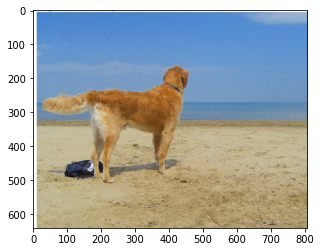

Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little boy in a blue shirt is playing in the water . <EOS>


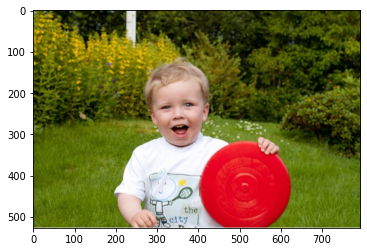

Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt and jeans walks down a street with a <UNK> in his hand . <EOS>


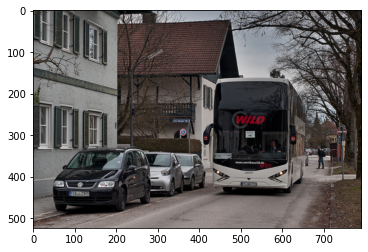

Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a canoe on a lake . <EOS>


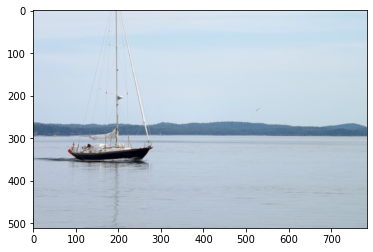

Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing on the side of a mountain . <EOS>


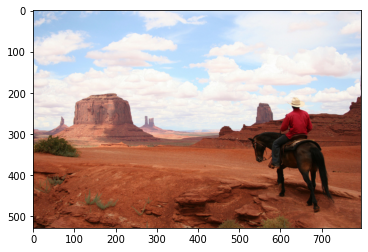

In [20]:
# Run the line below to see a couple of test cases
print_examples(model, device, dataset)